# YAMNET Classifier for Respiratory Sound Classification

Found 920 annotated recordings
X shape (6898, 1024) y pos rate 0.4720208756161206
Training XGBoost...
              precision    recall  f1-score   support

      normal       0.74      0.77      0.75       911
    abnormal       0.73      0.69      0.71       814

    accuracy                           0.73      1725
   macro avg       0.73      0.73      0.73      1725
weighted avg       0.73      0.73      0.73      1725



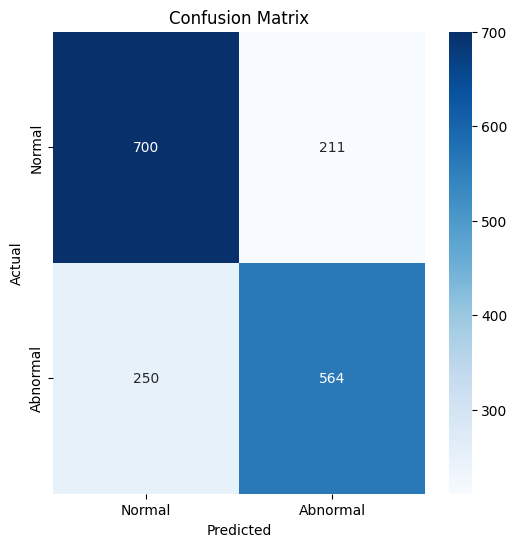

Saved XGBoost classifier as classifier_xgb.joblib


In [22]:
import os
import glob
import numpy as np
import librosa
from pathlib import Path
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import joblib
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ----------------------
# CONFIG
# ----------------------
DATA_DIR = r"C://Users/Malik/.cache/kagglehub/datasets/vbookshelf/respiratory-sound-database/versions/2/Respiratory_Sound_Database/Respiratory_Sound_Database"
AUDIO_DIR = os.path.join(DATA_DIR, "audio_and_txt_files")
ANN_DIR = AUDIO_DIR
SAMPLE_RATE = 16000

# ----------------------
# HELPERS
# ----------------------
def parse_ann(path):
    df = pd.read_csv(path, header=None, sep=r"\s+", engine='python', names=['start','end','crackle','wheeze'])
    return df

def list_pairs(audio_dir=AUDIO_DIR, ann_dir=ANN_DIR):
    files = glob.glob(os.path.join(audio_dir, "*.wav"))
    pairs = []
    for a in files:
        base = Path(a).stem
        ann = os.path.join(ann_dir, base + ".txt")
        if os.path.exists(ann):
            pairs.append((a, ann))
    return pairs

# ----------------------
# LOAD DATA
# ----------------------
pairs = list_pairs()
print("Found", len(pairs), "annotated recordings")

yamnet = hub.load('https://tfhub.dev/google/yamnet/1')

def yamnet_embeddings(waveform, sr=16000):
    scores, embeddings, spectrogram = yamnet(waveform)
    return embeddings.numpy(), scores.numpy()

# ----------------------
# BUILD EMBEDDINGS DATASET
# ----------------------
X = []
y = []

for wavpath, annpath in pairs:
    sig, sr = librosa.load(wavpath, sr=SAMPLE_RATE)
    df = parse_ann(annpath)
    for _, r in df.iterrows():
        s, e = float(r['start']), float(r['end'])
        seg = sig[int(s*sr):int(e*sr)]
        if len(seg) < 1600:
            continue
        if len(seg) < sr:
            seg = np.pad(seg, (0, sr - len(seg)))
        emb, _ = yamnet_embeddings(seg.astype(np.float32))
        emb_avg = emb.mean(axis=0)
        label = 1 if (int(r['crackle'])==1 or int(r['wheeze'])==1) else 0
        X.append(emb_avg)
        y.append(label)

X = np.vstack(X)
y = np.array(y)
print('X shape', X.shape, 'y pos rate', y.mean())

# ----------------------
# TRAIN/TEST SPLIT
# ----------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# ----------------------
# XGBOOST CLASSIFIER
# ----------------------
model = XGBClassifier(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    tree_method="hist"
)

print("Training XGBoost...")
model.fit(X_train, y_train)

# ----------------------
# EVALUATION
# ----------------------
preds = model.predict(X_test)
print(classification_report(y_test, preds, target_names=['normal','abnormal']))

cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal','Abnormal'], yticklabels=['Normal','Abnormal'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# ----------------------
# SAVE MODEL
# ----------------------
joblib.dump(model, "classifier_xgb.joblib")
print("Saved XGBoost classifier as classifier_xgb.joblib")


In [20]:

# ------------------------------
# FASTAPI BACKEND SECTION
# ------------------------------
from fastapi import FastAPI, UploadFile, File
from fastapi.responses import JSONResponse
import uvicorn
import soundfile as sf
import io
import joblib

app = FastAPI(title="Respiratory Annotator API")

# Try to load classifier if present
CLASSIFIER_PATH = 'classifier.joblib'
clf = None
try:
    clf = joblib.load(CLASSIFIER_PATH)
    print('Loaded classifier from', CLASSIFIER_PATH)
except Exception as e:
    print('No classifier.joblib found; backend will use rule-based fallback. Error:', e)

# Load yamnet lazily
_yamnet = None

def get_yamnet():
    global _yamnet
    if _yamnet is None:
        try:
            import tensorflow_hub as hub
            _yamnet = hub.load('https://tfhub.dev/google/yamnet/1')
            print('YAMNet loaded')
        except Exception as e:
            print('Failed to load YAMNet:', e)
            _yamnet = None
    return _yamnet


# Signal-based cycle detection (fast heuristic)
def detect_cycles(y, sr=22050, win_len=0.02, hop_len=0.01, energy_threshold=0.02, min_cycle_s=0.3):
    # Compute RMS envelope and pick peaks/valleys
    import numpy as np
    import librosa
    frame_length = int(sr * win_len)
    hop_length = int(sr * hop_len)
    rms = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)[0]
    times = librosa.frames_to_time(np.arange(len(rms)), sr=sr, hop_length=hop_length, n_fft=frame_length)
    # smooth
    rms_s = np.convolve(rms, np.ones(3)/3, mode='same')
    # thresholded mask
    mask = rms_s > energy_threshold
    # find contiguous regions
    regions = []
    in_reg = False
    start_t = 0.0
    for i, m in enumerate(mask):
        t = float(times[i])
        if m and not in_reg:
            in_reg = True
            start_t = t
        elif (not m) and in_reg:
            end_t = t
            if end_t - start_t >= min_cycle_s:
                regions.append((start_t, end_t))
            in_reg = False
    # handle case where audio ends inside region
    if in_reg:
        end_t = float(times[-1])
        if end_t - start_t >= min_cycle_s:
            regions.append((start_t, end_t))
    # Fallback: if no regions found, consider whole audio as one cycle
    if len(regions) == 0:
        regions = [(0.0, float(len(y)/sr))]
    return regions


# Feature: get yamnet average embedding for a segment

def segment_embedding(y, sr, yamnet_model):
    # yamnet expects 16k
    import numpy as np
    import librosa
    if sr != 16000:
        y16 = librosa.resample(y, orig_sr=sr, target_sr=16000)
    else:
        y16 = y
    # ensure float32
    y16 = y16.astype('float32')
    scores, embeddings, spec = yamnet_model(y16)
    emb = embeddings.numpy().mean(axis=0)
    return emb


# Heuristic wheeze/crackle detection (fallback)
def heuristic_classify_segment(y, sr):
    import numpy as np
    import scipy.signal
    # compute spectrogram
    f, t, Sxx = scipy.signal.spectrogram(y, fs=sr, nperseg=512, noverlap=256)
    # wheeze: narrowband harmonic energy in ~200-1000Hz for extended time
    band_idx = np.where((f >= 200) & (f <= 1000))[0]
    band_energy = Sxx[band_idx, :].mean(axis=0)
    # compute stability (std/mean) across time; wheeze shows sustained energy
    stability = band_energy.std() / (band_energy.mean() + 1e-9)
    # crackle: transient high-frequency spikes -> look at >1000Hz short bursts
    hf_idx = np.where(f > 1000)[0]
    hf_energy = Sxx[hf_idx, :].max()
    wheeze = int((band_energy.mean() > 1e-6) and (stability < 0.8))
    crackle = int(hf_energy > 1e-4)
    return {'wheeze': wheeze, 'crackle': crackle}


@app.post("/annotate")
async def annotate_audio(file: UploadFile = File(...)):
    """Accepts uploaded .wav file and returns JSON with detected cycles and wheeze/crackle labels.
    Request: multipart/form-data with file field.
    Response JSON: {cycles: [{start,end,wheeze,crackle,abnormal,confidence}, ...]}
    """
    contents = await file.read()
    # load audio with soundfile to preserve original sample rate
    import soundfile as sf
    import io
    bio = io.BytesIO(contents)
    y, sr = sf.read(bio, dtype='float32')
    if y.ndim > 1:
        y = y.mean(axis=1)

    # detect cycles (signal-based)
    cycles = detect_cycles(y, sr=sr)

    yam = get_yamnet()
    results = []
    for (s, e) in cycles:
        s_sample = int(s * sr)
        e_sample = int(e * sr)
        seg = y[s_sample:e_sample]
        if len(seg) < 10:
            continue
        # ML path
        if clf is not None and yam is not None:
            try:
                emb = segment_embedding(seg, sr, yam)
                prob = float(clf.predict_proba(emb.reshape(1,-1))[0,1]) if hasattr(clf, 'predict_proba') else float(clf.decision_function(emb.reshape(1,-1)))
                abnormal = int(prob > 0.5)
                # we don't have per-label crackle/wheeze from this classifier; return abnormal only
                results.append({'start': float(s), 'end': float(e), 'wheeze': None, 'crackle': None, 'abnormal': int(abnormal), 'confidence': prob})
                continue
            except Exception as e:
                print('ML path failed, falling back to heuristic:', e)
        # fallback heuristic
        h = heuristic_classify_segment(seg, sr)
        abnormal = int(h['wheeze'] or h['crackle'])
        results.append({'start': float(s), 'end': float(e), 'wheeze': int(h['wheeze']), 'crackle': int(h['crackle']), 'abnormal': int(abnormal), 'confidence': None})

    return JSONResponse({'cycles': results})


# If run directly, start server
if __name__ == '__main__':
    print('Starting server on http://127.0.0.1:8000')
    uvicorn.run('respiratory_demo_and_backend:app', host='0.0.0.0', port=8000, reload=True)


Loaded classifier from classifier.joblib
Starting server on http://127.0.0.1:8000


INFO:     Will watch for changes in these directories: ['c:\\Projects_etc\\hack-4-health-hackathon']
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)
INFO:     Started reloader process [30004] using StatReload
INFO:     Stopping reloader process [30004]
